# Pix2Pix

- Based on: https://arxiv.org/pdf/1611.07004.pdf
- Possible upgrade to cloud
- datasets from http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/

In [ ]:
import os
import time
import torch
import imageio
import itertools
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

from torch import nn
from tqdm.auto import tqdm
from torchvision.transforms import functional as F

## Architecture

### Generator
There are two generator architectures tested in the paper:
- encoder-decoder
- U-net
Where U-net differs from encoder-decoder only by additional skip connections from $i$th layer to $(n-i)$th.

#### Key features
- all convolutional (no fully-connected layers)
- encoder has convolutions that downsample by a factor of 2
- decoder has transposed convolutions that upsample by a factor of 2
- filter=4, stride=2
- uses L1 regularization
- *doesn't* use noise as its input, only dropout **at both training and test time**
- uses instance normalization instead of batch norm
- uses batch statistics at test time instead of aggregated training statistics

"Past conditional GANs (...)
provided Gaussian noise $z$ as an input to the generator, in
addition to $x$ (...). In initial experiments, we did not
find this strategy effective – the generator simply learned
to ignore the noise (...). Instead, **for our final models, we provide noise
only in the form of dropout**, applied on several layers of our
generator **at both training and test time**."

#### Encoder-Decoder

In [ ]:
class EncoderDecoderGenerator(torch.nn.Module):
    def __init__(self, optim, lambd=100, **kwargs):
        super(EncoderDecoderGenerator, self).__init__()

        # encoder
        # C64-C128-C256-C512-C512-C512-C512-C512
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, 4, stride=2, padding=1),
            nn.LeakyReLU(0.2, True), # no batch norm in the first layer

            nn.Conv2d(64, 128, 4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, True),

            nn.Conv2d(128, 256, 4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, True),

            nn.Conv2d(256, 512, 4, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, True),

            nn.Conv2d(512, 512, 4, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, True),

            nn.Conv2d(512, 512, 4, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, True),

            nn.Conv2d(512, 512, 4, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, True),

            nn.Conv2d(512, 512, 4, stride=2, padding=1),
            # nn.BatchNorm2d(512), # no batch norm in bottleneck layer
            nn.LeakyReLU(0.2, True)
        )

        # decoder
        # CD512-CD512-CD512-C512-C256-C128-C64
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 512, 4, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.Dropout(0.5),
            nn.ReLU(True),

            nn.ConvTranspose2d(512, 512, 4, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.Dropout(0.5),
            nn.ReLU(True),

            nn.ConvTranspose2d(512, 512, 4, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.Dropout(0.5),
            nn.ReLU(True),
        
            nn.ConvTranspose2d(512, 512, 4, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
        
            nn.ConvTranspose2d(512, 256, 4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
       
            nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(True),

            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),

            nn.ConvTranspose2d(64, 3, 4, stride=2, padding=1),
            nn.Tanh()
        )
        
        self.optim = optim(self.parameters(), **kwargs)
    
        for layer in self.encoder:
            if type(layer) != nn.LeakyReLU:
                torch.nn.init.normal_(layer.weight, 0, 0.02)
        for layer in self.decoder:
            if type(layer) not in [nn.ReLU, nn.Dropout, nn.Tanh]:
                torch.nn.init.normal_(layer.weight, 0, 0.02)
        
        self.l1 = torch.nn.L1Loss()
        self.lambd = lambd

    def eval(self):
        """Uses dropout during testing as a source of noise and nondeterminism."""
        for module in self.children():
            if type(module) != nn.Dropout:
                module.train(False)

    def forward(self, y):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    
    def loss(self, dis, y, target):
        x = self(y)
        p = dis(x, y)
        return dis.loss(p, target) + self.lambd * self.l1(p, target)

    def update(self, dis, y, device="cpu"):
        self.optim.zero_grad()
        loss = self.loss(dis, y, torch.ones(y.shape[0], 1).to(device))
        loss.backward()
        self.optim.step()
        return loss

#### U-Net

In [ ]:
class UNetGenerator(torch.nn.Module):
    def __init__(self, optim, lambd, **kwargs):
        super(UNetGenerator, self).__init__()

        # encoder
        # C64-C128-C256-C512-C512-C512-C512-C512
        self.en_1 = nn.Sequential(
            nn.Conv2d(3, 64, 4, stride=2, padding=1),
            nn.LeakyReLU(0.2, True) # no batch norm in the first layer
        )
        self.en_2 = nn.Sequential(
            nn.Conv2d(64, 128, 4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, True)
        )
        self.en_3 = nn.Sequential(
            nn.Conv2d(128, 256, 4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, True)
        )
        self.en_4 = nn.Sequential(
            nn.Conv2d(256, 512, 4, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, True)
        )
        self.en_5 = nn.Sequential(
            nn.Conv2d(512, 512, 4, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, True)
        )
        self.en_6 = nn.Sequential(
            nn.Conv2d(512, 512, 4, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, True)
        )
        self.en_7 = nn.Sequential(
            nn.Conv2d(512, 512, 4, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, True)
        )
        self.en_8 = nn.Sequential(
            nn.Conv2d(512, 512, 4, stride=2, padding=1),
            nn.LeakyReLU(0.2, True)
        )

        # decoder
        # CD512-CD1024-CD1024-C1024-C1024-C512-C256-C128 
        # For some reason there is one more layer in the U-net decoder in the paper
        # which causes (including last convolution with Tanh) to output 512x512 images
        # instead of 256x256
        # hence, I removed (for now) one C1024
        # there is also inconsistency with notation in the paper
        # since they first define Ck as Conv-BN-ReLU with k filters
        # and then use it in U-net decoder like it's k _channels_
        self.de_1 = nn.Sequential(
            nn.ConvTranspose2d(512, 512, 4, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.Dropout(0.5),
            nn.ReLU(True)
        )
        self.de_2 = nn.Sequential(
            nn.ConvTranspose2d(1024, 512, 4, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.Dropout(0.5),
            nn.ReLU(True)
        )
        self.de_3 = nn.Sequential(
            nn.ConvTranspose2d(1024, 512, 4, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.Dropout(0.5),
            nn.ReLU(True)
        )
        self.de_4 = nn.Sequential(
            nn.ConvTranspose2d(1024, 512, 4, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(True)
        )
        self.de_5 = nn.Sequential(
            nn.ConvTranspose2d(1024, 256, 4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(True)
        )
        self.de_6 = nn.Sequential(
            nn.ConvTranspose2d(512, 128, 4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(True)
        )
        self.de_7 = nn.Sequential(
            nn.ConvTranspose2d(256, 64, 4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(True)
        )
        self.de_8 = nn.Sequential(
            nn.ConvTranspose2d(128, 3, 4, stride=2, padding=1),
            nn.Tanh()
        )
        self.optim = optim(self.parameters(), **kwargs)
    
        for block in [self.en_1, self.en_2, self.en_3, self.en_4, self.en_5, self.en_6, self.en_7, self.en_8]:
            for layer in block:
                if type(layer) not in [nn.LeakyReLU, nn.InstanceNorm2d]:
                    torch.nn.init.normal_(layer.weight, 0, 0.02)
        for block in [self.de_1, self.de_2, self.de_3, self.de_4, self.de_5, self.de_6, self.de_7, self.de_8]:
            for layer in block:
                if type(layer) not in [nn.ReLU, nn.Dropout, nn.Tanh, nn.InstanceNorm2d]:
                    torch.nn.init.normal_(layer.weight, 0, 0.02)
        
        self.l1 = torch.nn.L1Loss()
        self.lambd = lambd
    
    def eval(self):
        """Uses dropout during testing as a source of noise and nondeterminism.
        Uses batchnorm during testing as instance normalization."""
        for module in self.children():
            if type(module) not in [nn.Dropout, nn.BatchNorm2d, nn.InstanceNorm2d]:
                module.train(False)

    def forward(self, y):
        x1 = self.en_1(y)
        x2 = self.en_2(x1)
        x3 = self.en_3(x2)
        x4 = self.en_4(x3)
        x5 = self.en_5(x4)
        x6 = self.en_6(x5)
        x7 = self.en_7(x6)
        x8 = self.en_8(x7)

        z = self.de_1(x8)
        z = self.de_2(torch.cat((z, x7), dim=1))
        z = self.de_3(torch.cat((z, x6), dim=1))
        z = self.de_4(torch.cat((z, x5), dim=1))
        z = self.de_5(torch.cat((z, x4), dim=1))
        z = self.de_6(torch.cat((z, x3), dim=1))
        z = self.de_7(torch.cat((z, x2), dim=1))
        z = self.de_8(torch.cat((z, x1), dim=1))
        return z
    
    def loss(self, dis, y, target):
        x = self(y)
        p = dis(x, y)
        return dis.loss(p, target) + self.lambd * self.l1(p, target)

    def update(self, dis, y, device="cpu"):
        self.optim.zero_grad()
        loss = self.loss(dis, y, torch.ones(y.shape[0], 1).to(device))
        loss.backward()
        self.optim.step()
        return loss

### Discriminator

#### Key features
- "PatchGAN", evaluates all NxN patches of input
- outputs matrix of probabilities
- end output is an average of that matrix
- convolutionally implemented sliding window

In [ ]:
class Pix2PixDiscriminator(torch.nn.Module):
    def __init__(self, optim, criterion, **kwargs):
        super(Pix2PixDiscriminator, self).__init__()
        self.criterion = criterion
        
        # 70x70
        # C64-C128-C256-C512
        # formula for receptive field: (output - 1) * stride + kernel
        # compute that for every layer starting with last one
        # (receptive field for next layer is output for previous layer)
        
        # 6 input channels because mask is concatenated (no idea if this is right,
        # just an idea since there is nothing about what to do with conditional input in the paper)
        self.model = nn.Sequential(
            nn.Conv2d(6, 64, 4, stride=2, padding=1),
            nn.LeakyReLU(0.2, True),

            nn.Conv2d(64, 128, 4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, True),

            nn.Conv2d(128, 256, 4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, True),

            nn.Conv2d(256, 512, 4, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, True),

            nn.Conv2d(512, 1, 4, stride=1, padding=1),
            nn.Sigmoid()
        )

        self.optim = optim(self.parameters(), **kwargs)

        for layer in self.model:
            if type(layer) not in [nn.LeakyReLU, nn.Sigmoid]:
                nn.init.normal_(layer.weight, 0, 0.02)

    def forward(self, x, y):
        x = torch.cat((x, y), dim=1)
        x = self.model(x)
        x = torch.mean(x, dim=(2,3))
        return x

    def loss(self, x, y):
        return self.criterion(x, y)

    def update(self, true_sample, gen_sample, cond, device="cpu"):
        self.optim.zero_grad()

        true_loss = self.loss(self(true_sample, cond), torch.ones(true_sample.shape[0], 1).to(device))
        prob = self(gen_sample, cond)
        false_loss = self.loss(prob, torch.zeros(gen_sample.shape[0], 1).to(device))

        # division by 2 to slow down D
        total_loss = (true_loss + false_loss) / 2
        total_loss.backward()
        self.optim.step()
        return total_loss, prob

## Helper functions
**TODO**: Move all of this to a separate file

In [ ]:
def gen_save_examples(path, gen, cond_gen, period, name_format, epoch_offset=0, device="cpu", stat=None, **kwargs):
    def save_examples(epoch, batch):
        if batch % period != 0:
            return
        gen.eval()
        imgA, imgB = next(cond_gen)
        imgB = imgB.to(device)
        examples = gen(imgB)
        if not os.path.isdir(path):
            os.mkdir(path)
        final = torch.cat((examples, imgB), dim=0)
        if stat is not None:
            std, mean = stat
            final = (std*final + mean)
        fullpath = os.path.join(path, name_format.format(epoch=(epoch_offset+epoch), batch=batch))
        torchvision.utils.save_image(final.detach(), fp=fullpath, **kwargs)
        gen.train()
    return save_examples

def gen_save_model(path, gen, dis, batch_size, period, name_format, epochperiod=1):
    def save_model(epoch, batch, stats):
        if epoch % period != 0:
            return
        if batch % period != 0:
            return
        if not os.path.isdir(path):
            os.mkdir(path)
        fullname = os.path.join(path, name_format.format(epoch=epoch, batch=batch))
        torch.save({
            "epoch": epoch,
            "batch_size": batch_size,
            "dis_state_dict": dis.state_dict(),
            "dis_optim_state_dict": dis.optim.state_dict(),
            "gen_state_dict": gen.state_dict(),
            "gen_optim_state_dict": gen.optim.state_dict(),
            "stats": stats
        }, fullname)
    return save_model

def gen_get_cond(dataset, batch_size, device="cpu"):
    test_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=0, drop_last=True)
    def get_cond():
        for imgA, imgB in itertools.cycle(test_loader):
            imgA, imgB = imgA.to(device), imgB.to(device)
            yield imgA, imgB
    return get_cond()

def load_model(path, gen, dis, device="cpu"):
    state = torch.load(path, map_location=torch.device(device))
    gen.load_state_dict(state["gen_state_dict"])
    gen.optim.load_state_dict(state["gen_optim_state_dict"])
    dis.load_state_dict(state["dis_state_dict"])
    dis.optim.load_state_dict(state["dis_optim_state_dict"])
    return state["epoch"], state["batch_size"], state.get("stats", {"dis": { "loss": [], "prob": []}, "gen": {"loss": []}})

def show_stats(stats):
    fig, (p1) = plt.subplots(nrows=1, ncols=1, figsize=(16, 9))

    p1.plot(stats["gen"]["loss"], color="blue", label="generator train loss")
    p1.plot(stats["dis"]["loss"], color="green", label="discriminator train loss")
    p1.set_xlabel("epochs")
    p1.set_ylabel("loss")
    p1.legend()

    plt.yscale("log")
    plt.show()

## Training loop
**TODO**: Move all of this to a separate file

In [ ]:
def train(gen, dis, loader, epochs, device="cpu", fw_snapshot=None, model_snapshot=None, k=1, k2=1):
    print(f"Using device: {device}")
    stats = {'dis': {
        'loss': [],
        'prob': []
    }, 'gen': {
        'loss': [] 
    }}
    gen.train()
    dis.train()

    try:
        for i in range(epochs):
            pbar = tqdm(enumerate(iter(loader)), total=len(loader))
            pbar.set_description("epoch %s/%s" % (i, epochs))
            dloss, pr = 0, 0
            gloss = 0
            for j, (images, masks) in pbar:
                images, masks = images.to(device), masks.to(device)
                batch_prob, batch_dloss, batch_gloss = 0, 0, 0
                for _ in range(k):
                    l, p = dis.update(images, gen(masks).to(device), masks, device=device)
                    batch_dloss += l
                    batch_prob += p
                for _ in range(k2):
                    batch_gloss += gen.update(dis, masks, device=device)
                batch_prob = float(torch.mean(batch_prob) / k)
                batch_dloss = float(torch.mean(batch_dloss) / k)
                batch_gloss = float(torch.mean(batch_gloss) / k2)
                dloss += batch_dloss
                gloss += batch_gloss
                pr += batch_prob
                pbar.write("D(G(z)): %.2f, generator loss: %.2f, discriminator loss: %.2f" % 
                           (float(batch_prob), float(batch_gloss), float(batch_dloss)), end="\r")
                if fw_snapshot is not None:
                    fw_snapshot(i, j)
                if model_snapshot is not None:
                    model_snapshot(i, j, stats)
            stats['gen']['loss'].append(gloss / len(loader))
            stats['dis']['prob'].append(pr / len(loader))
            stats['dis']['loss'].append(dloss / len(loader))
    except KeyboardInterrupt:
        if model_snapshot is not None:
            model_snapshot("%s_KeyboardInterrupt" % epochs, 0, stats)
    gen.eval()
    dis.eval()
    return stats

## Experiment 1: Facades

### Load the dataset

In [ ]:
from data_loaders import Facades
import ab_transforms as abt

std, mean = 0.5, 0.5

facades_train = Facades(root="datasets", folder="train", download=True,
                        transform=abt.Compose([abt.ToTensor(),
                                               abt.RandomJitter((286,286), (256,256)),
                                               abt.RandomHorizontalFlip(),
                                               abt.Normalize(mean, std)]))
facades_test = Facades(root="datasets", folder="test", download=False,
                        transform=abt.Compose([abt.ToTensor(), abt.Normalize(mean, std)]))

### Dataset preview

In [ ]:
facades_test_loader = torch.utils.data.DataLoader(facades_test, batch_size=16, shuffle=True, num_workers=0)
facades_test_iter = iter(facades_test_loader)
img, masks = facades_test_iter.next()

fig, ax = plt.subplots(figsize=(14,14))
images = std*torch.cat((img, masks), dim=0) + mean
ax.imshow(torchvision.utils.make_grid(images).numpy().transpose(1,2,0), cmap="gray")

try:
    print(dis(img, masks).T)
except NameError:
    pass

### Training

In [ ]:
BATCH_SIZE = 1
LR = 0.0002
BETAS = (0.5, 0.999)
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
LAMBDA = 100
EPOCHS = 100
EPOCH_OFFSET = 0

#gen = Pix2PixGenerator(optim=torch.optim.Adam, lr=LR, betas=BETAS).to(DEVICE)
gen = UNetGenerator(optim=torch.optim.Adam, lr=LR, betas=BETAS, lambd=LAMBDA).to(DEVICE)
dis = Pix2PixDiscriminator(optim=torch.optim.Adam, criterion=torch.nn.BCELoss(), lr=LR, betas=BETAS).to(DEVICE)

try:
    from google.colab import drive
    drive.mount('/content/drive')
    img_path = "drive/MyDrive/images/%s"
except ImportError:
    print("Not running on Colab. Skipping drive mount.")
    img_path = "images/%s"

In [ ]:
TIME = "2021-01-10_14-45" #time.strftime("%Y-%m-%d_%H-%M", time.localtime())

fw_snapshot = gen_save_examples(img_path % TIME, gen, cond_gen=gen_get_cond(facades_test, 16),
                                epoch_offset=EPOCH_OFFSET,
                                period=200, name_format="{epoch}_{batch}.png",
                                nrow=8, padding=0, device=DEVICE, stat=(std,mean))
model_snapshot = gen_save_model("models/", gen, dis, BATCH_SIZE, period=400,
                               name_format="facades_%s_{batch}" % TIME)

dataloader = torch.utils.data.DataLoader(facades_train, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, drop_last=True)
stats = train(gen, dis, dataloader, epochs=EPOCHS, device=DEVICE, fw_snapshot=fw_snapshot, model_snapshot=model_snapshot)

### Loss plot

In [ ]:
show_stats(stats)

### Save

In [ ]:
try:
    if drive:
        path = "drive/MyDrive/models/"
except NameError:
    print("Drive not mounted.")
    path = "models/"

fullname=os.path.join(path, "facades_200epochs_%s" % TIME)
if not os.path.isdir(path):
    os.mkdir(path)
torch.save({
    "epoch": EPOCH_OFFSET + EPOCHS,
    "batch_size": BATCH_SIZE,
    "dis_state_dict": dis.state_dict(),
    "dis_optim_state_dict": dis.optim.state_dict(),
    "gen_state_dict": gen.state_dict(),
    "gen_optim_state_dict": gen.optim.state_dict(),
    "stats": stats
}, fullname)

In [ ]:
with imageio.get_writer("images/%s/result_test.gif" % TIME, mode='I', duration=0.1) as writer:
    for i in range(5):
        step = i * 5 +  1
        writer._duration = 0.1 * i + 0.1
        for filename in ["images/%s/%d_%d.png" % (TIME, i, j) for j in range(0, len(dataloader), step)]:
            image = imageio.imread(filename)
            writer.append_data(image)

### Load

In [ ]:
# '2' to potentially not overwrite existing models' data
gen2 = UNetGenerator(optim=torch.optim.Adam).to(DEVICE)
dis2 = Pix2PixDiscriminator(optim=torch.optim.Adam, criterion=torch.nn.BCELoss()).to(DEVICE)

try:
    if drive:
        model_path = "drive/MyDrive/models/facades_%sepochs_colab_%s" % (100, TIME)
except NameError:
    print("Drive not mounted.")
    model_path = "models/facades_%sepochs_%s" % (200, TIME)

EPOCHS2, BATCH_SIZE2, stats2 = load_model(model_path, gen2, dis2, device=DEVICE)
print(EPOCHS2, BATCH_SIZE2)
show_stats(stats2)

### Generator preview

In [ ]:
imgs, masks = facades_test_iter.next()
imgs, masks = imgs.to(DEVICE), masks.to(DEVICE)
gen2.eval()
dis2.eval()
examples = gen2(masks)

fig, ax = plt.subplots(figsize=(14,14))
combined = std*torch.cat((examples.detach(), imgs, masks), dim=0) + mean
ax.imshow(torchvision.utils.make_grid(combined.cpu()).cpu().numpy().transpose(1,2,0), cmap="gray")

try:
    print(dis2(examples, masks).T)
except NameError:
    pass

## Experiment 2: Maps (aerial to map)

### Load the dataset

In [ ]:
from data_loaders import Maps
import ab_transforms as abt

std, mean = 0.5, 0.5

#TODO: Check in their code if they do normalization

maps_train = Maps(root="datasets", folder="train", download=True,
                  transform=abt.Compose([abt.ToTensor(),
                                         abt.Resize((256, 256)),
                                         abt.RandomJitter((286,286), (256,256)),
                                         abt.RandomHorizontalFlip(),
                                         abt.Normalize(mean, std)]))
maps_test = Maps(root="datasets", folder="val", download=False,
                 transform=abt.Compose([abt.ToTensor(), abt.Resize((256, 256)),
                                        abt.Normalize(mean, std)]))

### Dataset preview

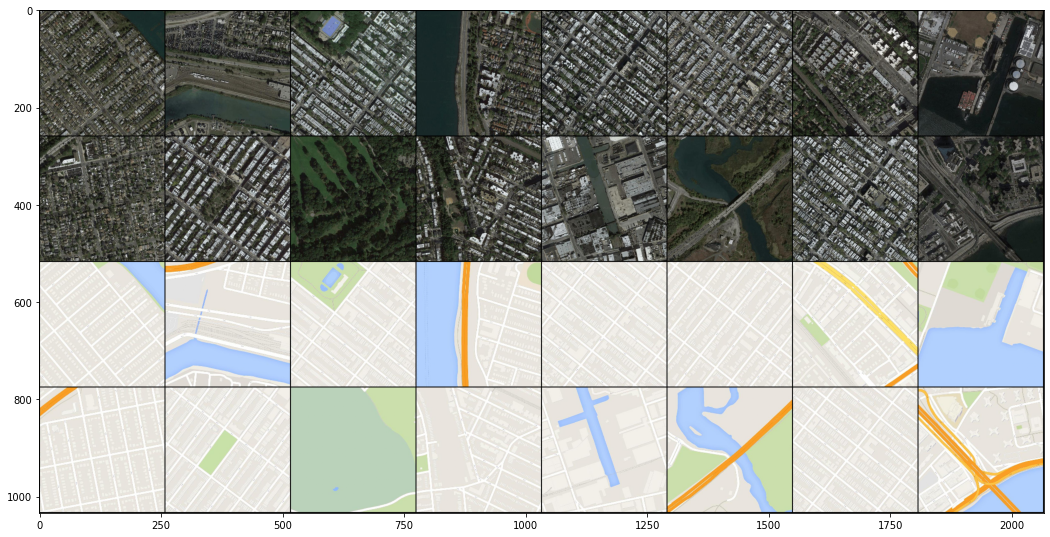

In [ ]:
maps_test_loader = torch.utils.data.DataLoader(maps_test, batch_size=16, shuffle=True, num_workers=0)
maps_test_iter = iter(maps_test_loader)
imgA, imgB = maps_test_iter.next()

fig, ax = plt.subplots(figsize=(18,18))
images = std*torch.cat((imgA, imgB), dim=0) + mean
# images = torch.cat((imgA, imgB), dim=0)
ax.imshow(torchvision.utils.make_grid(images).numpy().transpose(1,2,0), cmap="gray")

try:
    print(dis(imgA.to(DEVICE), imgB.to(DEVICE)).T)
except NameError:
    pass

### Training

In [ ]:
BATCH_SIZE = 1
LR = 0.0002
BETAS = (0.5, 0.999)
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
LAMBDA = 100
print("Device: %s" % torch.cuda.get_device_name(DEVICE))

gen = UNetGenerator(optim=torch.optim.Adam, lr=LR, betas=BETAS, lambd=100).to(DEVICE)
dis = Pix2PixDiscriminator(optim=torch.optim.Adam, criterion=torch.nn.BCELoss(), lr=LR, betas=BETAS).to(DEVICE)

try:
    from google.colab import drive
    drive.mount('/content/drive')
    img_path = "drive/MyDrive/images/%s"
    model_path = "drive/MyDrive/models/"
except ImportError:
    print("Not running on Colab. Skipping drive mount.")
    img_path = "images/%s"
    model_path = "models/"

Device: Tesla K80
Mounted at /content/drive


In [ ]:
EPOCHS = 10
EPOCH_OFFSET = 190
TIME = "2021-01-12_16-52" #time.strftime("%Y-%m-%d_%H-%M", time.localtime())

fw_snapshot = gen_save_examples(img_path % TIME, gen, cond_gen=gen_get_cond(maps_test, 16),
                                epoch_offset=EPOCH_OFFSET,
                                period=1000, name_format="{epoch}_{batch}.png",
                                nrow=8, padding=0, device=DEVICE, stat=(std,mean))
model_snapshot = gen_save_model(model_path, gen, dis, BATCH_SIZE, period=1096, epochperiod=5,
                               name_format="mapsA2B_%s__{batch}" % TIME)

dataloader = torch.utils.data.DataLoader(maps_train, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, drop_last=True)
stats_tmp = train(gen, dis, dataloader, epochs=EPOCHS, device=DEVICE, fw_snapshot=fw_snapshot, model_snapshot=model_snapshot)
try:
    if stats:
        stats["gen"]["loss"] = stats["gen"]["loss"] + stats_tmp["gen"]["loss"]
        stats["dis"]["loss"] = stats["dis"]["loss"] + stats_tmp["dis"]["loss"]
        stats["dis"]["prob"] = stats["dis"]["prob"] + stats_tmp["dis"]["prob"]
except NameError:
    stats = stats_tmp

Using device: cuda:0


D(G(z)): 0.02, generator loss: 100.60, discriminator loss: 0.24


D(G(z)): 0.16, generator loss: 94.31, discriminator loss: 0.12


D(G(z)): 0.15, generator loss: 99.90, discriminator loss: 0.12


D(G(z)): 0.05, generator loss: 100.57, discriminator loss: 0.06


D(G(z)): 0.07, generator loss: 98.81, discriminator loss: 0.07


D(G(z)): 0.05, generator loss: 99.67, discriminator loss: 0.07


D(G(z)): 0.02, generator loss: 102.74, discriminator loss: 0.05


D(G(z)): 0.05, generator loss: 97.60, discriminator loss: 0.11


D(G(z)): 0.13, generator loss: 103.95, discriminator loss: 0.12


D(G(z)): 0.08, generator loss: 99.31, discriminator loss: 0.10


### Loss plot

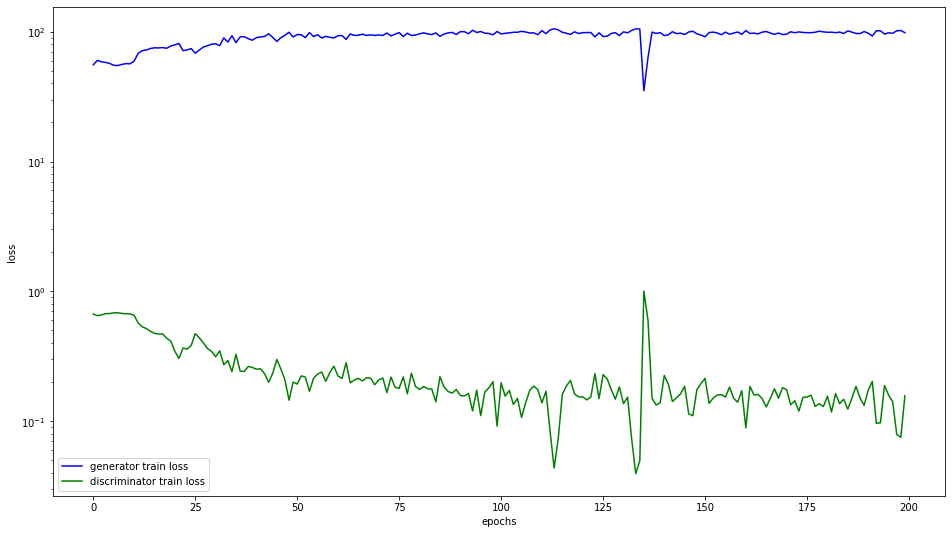

In [ ]:
show_stats(stats)

### Save

In [ ]:
try:
    if drive:
        path = "drive/MyDrive/models/"
except NameError:
    print("Drive not mounted.")
    path = "models/"

fullname=os.path.join(path, "mapsA2B_%sepochs_%s" % (EPOCH_OFFSET + EPOCHS, TIME))
if not os.path.isdir(path):
    os.mkdir(path)
torch.save({
    "epoch": EPOCH_OFFSET + EPOCHS,
    "batch_size": BATCH_SIZE,
    "dis_state_dict": dis.state_dict(),
    "dis_optim_state_dict": dis.optim.state_dict(),
    "gen_state_dict": gen.state_dict(),
    "gen_optim_state_dict": gen.optim.state_dict(),
    "stats": stats
}, fullname)

In [ ]:
with imageio.get_writer("images/%s/result_test.gif" % TIME, mode='I', duration=0.1) as writer:
    for i in range(5):
        step = i * 5 +  1
        writer._duration = 0.1 * i + 0.1
        for filename in ["images/%s/%d_%d.png" % (TIME, i, j) for j in range(0, len(dataloader), step)]:
            image = imageio.imread(filename)
            writer.append_data(image)

### Load

In [ ]:
# '2' to potentially not overwrite existing models' data
gen2 = UNetGenerator(optim=torch.optim.Adam, lambd=100).to(DEVICE)
dis2 = Pix2PixDiscriminator(optim=torch.optim.Adam, criterion=torch.nn.BCELoss()).to(DEVICE)

try:
    if drive:
        load_path = "drive/MyDrive/models/mapsA2B_%sepochs_%s" % (EPOCH_OFFSET + EPOCHS, TIME)
except NameError:
    print("Drive not mounted.")
    load_path = "models/mapsA2B_%sepochs_%s" % (200, TIME)

EPOCHS2, BATCH_SIZE2, stats2 = load_model(load_path, gen2, dis2, device=DEVICE)
print(EPOCHS2, BATCH_SIZE2)

120 1


### Generator preview

tensor([[0.0211, 0.0208, 0.0366, 0.0347, 0.0148, 0.0107, 0.0101, 0.0241, 0.0184,
         0.0264, 0.0046, 0.0334, 0.0103, 0.0180, 0.0354, 0.0151]],
       device='cuda:0', grad_fn=<PermuteBackward>)


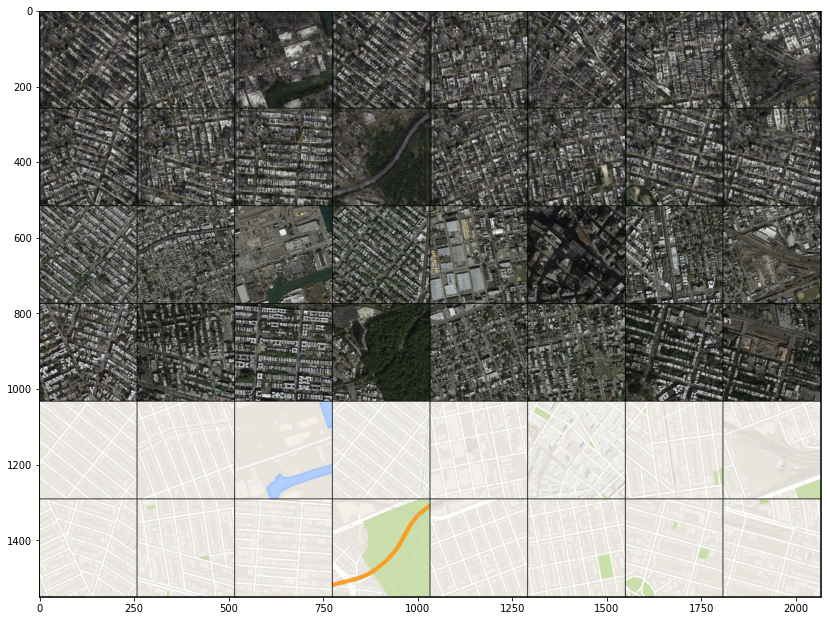

In [ ]:
imgs, masks = maps_test_iter.next()
imgs, masks = imgs.to(DEVICE), masks.to(DEVICE)
gen.eval()
dis.eval()
examples = gen(masks)

fig, ax = plt.subplots(figsize=(14,14))
combined = std*torch.cat((examples.detach(), imgs, masks), dim=0) + mean
# combined = torch.cat((examples.detach(), imgs, masks), dim=0)
ax.imshow(torchvision.utils.make_grid(combined.cpu()).cpu().numpy().transpose(1,2,0), cmap="gray")

try:
    print(dis(examples, masks).T)
except NameError:
    pass